In [1]:
import sys
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.model_selection import train_test_split
from tools import proccess_data
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler


In [2]:
def get_dataset_list(data_list):
    dict = {}
    for data_name in data_list:
        edge_path = '../../AMLsim/outputs/'+data_name+'/tx_log.csv'
        node_path = '../../AMLsim/outputs/'+data_name+'/node_log.csv'
        edge_data = pd.read_csv(edge_path)
        node_data = pd.read_csv(node_path)
        features, labels = proccess_data(edge_data, node_data)#, true_labels = proccess_data(edge_data, node_data)
        features = features.drop(['node_id'], axis=1)
        labels = labels.drop(['node_id'], axis=1)
        #true_labels = true_labels.drop(['node_id'], axis=1)
# Normalize the features
        scaler = StandardScaler()
        features = scaler.fit_transform(features)
        dict[data_name] = [features, labels] #, true_labels]

    return dict
        

In [3]:
# data_name_list = ['100K_accts_BENCH', 
#                   '100K_accts_BENCH_HARDER', 
#                   '100K_accts_BENCH_HARDER2', 
#                   '100K_accts_BENCH_HARDER3', 
#                   '100K_accts_BENCH_SAMEDIST',
#                   '100K_accts_BENCH_SAMEEVERYTHING',
#                   '100K_accts_BENCH_SAMEEVERYTHING_GAMMA']

# data_name_list = ['100K_accts_BENCH', 
#                   '100K_accts_BENCH_MID',
#                   '100K_accts_BENCH_HARDER']

data_name_list = ['100K_accts_MID5']

data_dict = get_dataset_list(data_name_list)

print('ALL data is loaded')

: 

In [ ]:
# data_name = '100K_accts_BENCH_MID_EA_25'
data_name = '100K_accts_MID5'

edge_path = '../../AMLsim/outputs/'+data_name+'/tx_log.csv'
node_path = '../../AMLsim/outputs/'+data_name+'/node_log.csv'

edge_data = pd.read_csv(edge_path)
node_data = pd.read_csv(node_path)
#features, labels, true_labels = proccess_data(edge_data, node_data)
features, labels = proccess_data(edge_data, node_data)

print(features.head())

features = features.drop(['node_id'], axis=1)
labels = labels.drop(['node_id'], axis=1)
#true_labels = true_labels.drop(['node_id'], axis=1)


# Normalize the features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Remove previous data named data_name
if data_name in data_dict:
    del data_dict[data_name]

# Append to data_dict
data_dict[data_name] = [features, labels] #, true_labels]

print('Data is added')


   node_id  avg_amount_sent  total_amount_sent  total_transactions_sent  \
0        0           959.96          193911.81                      202   
1        1          1186.17          263330.57                      222   
2        2           716.11          148234.69                      207   
3        3          2300.47          478498.27                      208   
4        4           831.54          165475.85                      199   

   avg_amount_rec  total_amount_rec  total_transactions_rec  \
0         5270.16         258237.98                      49   
1         5518.50         320072.80                      58   
2         2774.09         130382.16                      47   
3        13482.53         714574.11                      53   
4         2735.99         169631.39                      62   

   avg_phone_changes  total_phone_changes  INIT_BALANCE  BANK_ID  \
0                0.0                    0      23512.34        0   
1                0.0              

In [ ]:
#name_of_data = '100K_accts_BENCH_MID_EA'
name_of_data = '100K_accts_MID5'

features = data_dict[name_of_data][0]
labels = data_dict[name_of_data][1]
#true_labels = data_dict[name_of_data][2]

# Change shape to (n_samples,)
labels = np.ravel(labels)
#true_labels = np.ravel(true_labels)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42) # 2 
#_, _, y_train_true, y_test_true = train_test_split(features, true_labels, test_size=0.2, random_state=42)

print('Data is chosen and split')

Data is chosen and split


In [ ]:
untouched_features = features

In [248]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {'kernel': ['rbf']}
# grid = GridSearchCV(svm.SVC(), param_grid, cv=5,scoring='average_precision', refit=True, verbose=3)

# grid.fit(X_train, y_train)


In [249]:
tree_model = tree.DecisionTreeClassifier(class_weight='balanced', max_depth=9, min_samples_leaf=9, min_samples_split=9) # Grid Searched
tree_model.fit(X_train, y_train)

print('Model is trained')

Model is trained


In [250]:
from sklearn.ensemble import GradientBoostingClassifier

# Oversample the positive class
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(sampling_strategy=0.7)

X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

from sklearn.metrics import confusion_matrix

def fpr_score(model, X, y_true):
    y_pred = model.predict(X)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tp)

from sklearn.model_selection import GridSearchCV
param_grid = {
    'learning_rate': [0.1],
    'max_depth': [9,11],
    'min_samples_leaf': [9,11],
    'min_samples_split': [9,11]
}

# Sample so the model becomes more sensitive to the positive class
sample_weight = np.ones(y_train_ros.shape[0])
sample_weight[y_train_ros==1] = 15 # 25

# grid = GridSearchCV(GradientBoostingClassifier(n_estimators=100), param_grid, cv=4, scoring=fpr_score, refit=True, verbose=3)

# grid.fit(X_train_ros, y_train_ros)

# print(grid.best_params_)


In [251]:

xdgboost_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=5,min_samples_leaf=5, min_samples_split=5)
xdgboost_model.fit(X_train_ros, y_train_ros, sample_weight)

print('Model is trained')

In [252]:
def precision_after_recall(model, X, y_true):
    from sklearn.metrics import precision_recall_curve
    y_pred = model.predict_proba(X)[:,1]
    precision, recall, threshold = precision_recall_curve(y_true, y_pred)
    desired_recall = 0.75
    idx = np.argmax(recall <= desired_recall)
    return precision[idx]


In [253]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# param_grid = {'max_depth': [15,17,19],'min_samples_leaf': [11],'min_samples_split': [9]}

# grid = GridSearchCV(RandomForestClassifier(n_estimators=100), param_grid, cv=5, scoring=precision_after_recall, refit=True, verbose=3)
# grid.fit(X_train_ros, y_train_ros)

# print(grid.best_params_)

# random_forest_model = RandomForestClassifier(n_estimators=100, max_depth=31, min_samples_leaf=11, min_samples_split=9) # Grid Searched
random_forest_model = RandomForestClassifier(n_estimators=100, max_depth=21, min_samples_leaf=11, min_samples_split=9) 

random_forest_model.fit(X_train_ros,y_train_ros,sample_weight)

print('Model is trained')

Model is trained


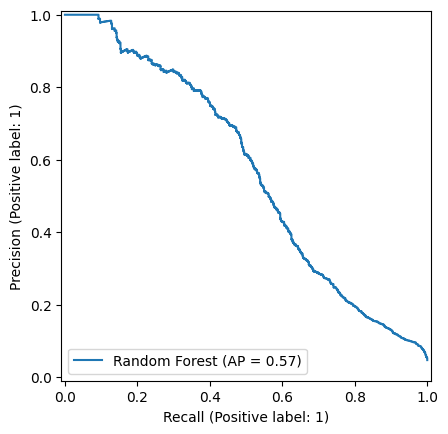

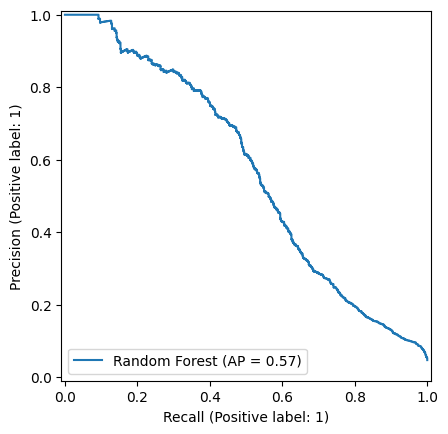

In [254]:
from sklearn.metrics import PrecisionRecallDisplay

# display = PrecisionRecallDisplay.from_estimator(svm_model, X_test, y_test, name='SVM')
# display.plot()

# In the same plot, plot all the different models precision-recall curves, using the models not the predictions
names = ['Random Forest']
models = [random_forest_model]
fig, ax = plt.subplots()
for i, model in enumerate(models):
    display = PrecisionRecallDisplay.from_estimator(model, X_test, y_test, name=names[i])
    display.plot(ax=ax)

In [255]:
from sklearn.metrics import precision_recall_curve

model = random_forest_model

y_true = y_test
y_scores = model.predict_proba(X_test)[:,1]

# Assuming 'y_true' is your true labels and 'y_scores' are the predicted probabilities
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Get the threshold where recall = 
desired_recall = 0.8

threshold = thresholds[np.argmax(recall <= desired_recall)]
# print(threshold)

# Confusion matrix
from sklearn.metrics import confusion_matrix

# y_pred = xdgboost_model.predict(X_test)
y_pred = model.predict_proba(X_test)

y_pred = (y_pred[:,1] > threshold).astype(int)

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# print("Precision: ", precision_score(y_test, y_pred))

# Calculate false positive rate
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print(fp)

fpr = fp/(fp+tp)
print('False positive rate:', fpr)

# Display the confusion matrix nicely


[[15969  3092]
 [  188   751]]
3092
False positive rate: 0.8045797553994275


In [256]:
# Print the important features
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 11 (0.196815)
2. feature 10 (0.191178)
3. feature 3 (0.114771)
4. feature 4 (0.104412)
5. feature 1 (0.103468)
6. feature 0 (0.089508)
7. feature 2 (0.076471)
8. feature 8 (0.070574)
9. feature 5 (0.052060)
10. feature 7 (0.000376)
11. feature 6 (0.000368)
12. feature 9 (0.000000)


In [257]:
# Tunead
# BENCH
# False positive rate: 0.6086503387180824

# MID_EA
# False positive rate: 0.8046814044213264

# MID
# False positive rate: 0.8247254031315728

# HARDER
# False positive rate: 0.8343260533862784


In [258]:
# Recall = 0.7
# Otunead model
# BENCH
# False positive rate: 0.6373464373464374

# SAMEEVERYTHING
# False positive rate: 0.9411801358340084


In [259]:
# HARDER 3
# FPR 0.9236391129032258

In [260]:
# BENCH
# AP: TREE 0.75, XGB: 0.77
# XGB FPR: 0.915
# RF FPR: 0.93

# BENCH_HARDER
# AP: TREE 0.58, XGB: 0.64
# FPR: 0.92

# BENCH_HARDER2
# AP: TREE 0.55, XGB: 0.62
# FPR: 0.92

# BENCH_HARDER3
# AP: TREE 0.56, XGB: 0.61
# FPR: 0.92

# SAMEDIST
# AP: TREE 0.57, XGB: 0.62
# FPR: 0.53

# SAMEEVERYTHING
# XGB FPR: 0.92
# RF FP: 0.95

In [261]:
FP = 495
TN = 18938
print(FP/(FP+TN))

0.025472135028045077


In [262]:
frac = 80/83
print(frac*100)

96.3855421686747
